# User behavior as a predictor for input accuracy
Johann Miller, University of Maryland Makeability Lab

## Introduction
[Project Sidewalk](http://sidewalk.umiacs.umd.edu) is an online platform for identifying accessibility problems in sidewalks. Users navigate streets using Google Street View, and place labels on issues such as crosswalks without curbramps, uneven pavement, and obstacles blocking the path. In order to ensure some level of accuracy in the data, Project Sidewalk can use a couple tools. Each user has to complete a tutorial before they can begin to report problems. Another option is ground truth seeding, where users place labels in a region that already has established answers. If the user enters data that doesn't match the ground truth, then all of the data they entered can be flagged.

Here, we will investigate another possible option: using the user's interactions with the tool to predict their accuracy. Consider a user who is inactive for long periods, and barely uses any of the tool's features. This user probably gives worse input than a user who works consistently and employs all of the tool's features. Aspects of interaction include mouse movement, keypresses, and others that we can collect while users place labels. If accurate labels correspond to a certain type of usage, then these features could predict the accuracy of a user even in non ground truth regions.

To see if this is possible, we'll use data from ground truth regions to train and test a classifier.

## Setup python notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%html
<style>
img {margin-left: 0!important} /* left align images */
</style>

## Collecting user events
Project Sidewalk has logs for variety of user events. The events range from low-level (mouse movements, clicks, etc.) to high-level (zoom in/out, changing label mode, etc.). If we query the interaction table, we can see all the event types.

In [3]:
event_types = pd.read_csv('data/interim/event-types.csv')
print('Num of event types:', len(event_types))
event_types.head()

Num of event types: 109


,event_type
0,Click_LabelDelete
1,Click_ModeSwitch_CurbRamp
2,Click_ModeSwitch_NoCurbRamp
3,Click_ModeSwitch_NoSidewalk
4,Click_ModeSwitch_Obstacle


For each user session, we have a collection of the events that were triggered. In order to compare two sessions, we can look at the total number of each type of event. We also look at the mean and standard deviation of the number of events per Google Street View panorama. This way, a user session in a large region can be compared fairly to a session in a smaller region since the former will have more panoramas.

We can load in these event counts from `features.csv`. This file was created by **TODO**.

In [4]:
features = pd.read_csv('data/interim/feature-names.csv')
print('Num of features:', len(features))
features.head()

Num of features: 327


,feature
0,Click_LabelDelete_per_pan_mean
1,Click_LabelDelete_per_pan_std
2,Click_LabelDelete_total
3,Click_ModeSwitch_CurbRamp_per_pan_mean
4,Click_ModeSwitch_CurbRamp_per_pan_std


## Grading user accuracy
We need to rate each user session on its accuracy compared to the ground truth. We do so by counting the number of true positives, false positives, true negatives, and false negatives from the session. These are defined as follows:

#### True positive
The user placed a correct label. Here, the green icon is a label for a curb ramp. The user placed it correctly, so this is a true positive.

![true positive](images/true-pos.png)

#### False positive
The user placed an incorrect label. Here, the user placed a green icon to identify a curb ramp, but none are present.

![false positive](images/false-pos.png)

#### True negative
There was nothing to label, and the user didn't label anything. The amount of empty space necessary to be considered a true negative is the `granularity`. The scoring was done with three values: 5 meter, 10 meter, and street.

![true negative](images/true-neg.png)

#### False negative
There was something to label, but the user missed it. Here, there is a curb ramp with no label.

![false negative](images/false-neg.png)

In [5]:
raw_scores = pd.read_csv('data/interim/processing/scores.csv')
raw_scores.head()

,condition_id,worker_id,type,granularity,label.type,true_pos,false_pos,true_neg,false_neg
0,70,01232fef-5a19-4435-8be6-c0da3b38cabd,volunteer,5_meter,Problem,27,26,186,17
1,70,01232fef-5a19-4435-8be6-c0da3b38cabd,volunteer,10_meter,Problem,27,15,76,12
2,70,01232fef-5a19-4435-8be6-c0da3b38cabd,volunteer,street,Problem,17,0,0,0
3,72,9501513f-3822-4921-861e-8f1440dee102,volunteer,5_meter,Problem,22,58,161,7
4,72,9501513f-3822-4921-861e-8f1440dee102,volunteer,10_meter,Problem,21,44,59,3


### Composite scores
We can combine the counts of true positives, true negatives, etc. into metrics that tell us about the accuracy of the user.

$\text{accuracy} = \frac{\text{true positives + true negatives}}{\text{true positives + false positives + true negatives + false negatives}}$

$\text{positive predictive value (ppv)} = \frac{\text{true positives}}{\text{true positives + false positives}}$

$\text{negative predictive value (npv)} = \frac{\text{true negatives}}{\text{true negatives + false negatives}}$

$\text{recall} = \frac{\text{true positives}}{\text{true positives + false negatives}}$

$\text{specificity} = \frac{\text{true positives}}{\text{true positives + true negatives}}$

In [6]:
scores = pd.read_csv('data/interim/processing/scores-comb-acc.csv')
scores[scores.columns[4:]].head()

,true_pos,false_pos,true_neg,false_neg,accuracy,ppv,npv,recall,specificity
0,116,86,1564,54,0.923077,0.574257,0.966625,0.682353,0.947879
1,112,136,3262,74,0.941406,0.451613,0.977818,0.602151,0.959976
2,76,18,140,4,0.907563,0.808511,0.972222,0.950000,0.886076
3,120,110,1564,99,0.889593,0.521739,0.940469,0.547945,0.934289
4,95,151,3264,132,0.922295,0.386179,0.961131,0.418502,0.955783


### Data exploration
Now that we've collected features for user interaction and labeled them based on accuracy, we can begin to examine it.

In [19]:
from sklearn import preprocessing

data = pd.read_csv('data/final/interaction-comb.csv')

label_cols = data.columns[8:13].tolist()
feature_cols = data.columns[13:].tolist()

#### Size of the data

In [20]:
print('Num of users:', len(data[['condition_id', 'worker_id']].drop_duplicates()))
print('  Num of turkers:', len(data[data.type == 'turker'][['condition_id', 'worker_id']].drop_duplicates()))
print('  Num of volunteers:', len(data[data.type == 'volunteer'][['condition_id', 'worker_id']].drop_duplicates()))
print('Num of features:', len(feature_cols))

Num of users: 308
  Num of turkers: 264
  Num of volunteers: 44
Num of features: 327


We have more features than samples, meaning our data is probably sparse. 

#### Feature correlation

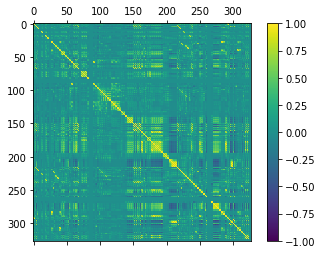

In [167]:
features = data[data.granularity == 'street'][feature_cols]
features = pd.DataFrame(preprocessing.scale(features))

correlations = features.corr().fillna(0)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

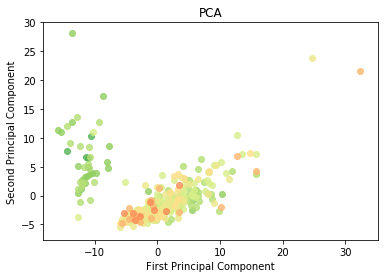

User Accuracy


In [172]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import branca

# Create a regular PCA model 
pca = PCA(n_components=2)

# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(features)

colormap = branca.colormap.linear.RdYlGn.scale(0, 1)

step = 0.1
for i in np.arange(0, 1, step): # for each bucket
    i = 1 - i - step # reverse
    x = reduced_data_pca[:,0][(labels.accuracy >= i) & (labels.accuracy < i + step)]
    y = reduced_data_pca[:,1][(labels.accuracy >= i) & (labels.accuracy < i + step)]
    plt.scatter(x=x, y=y, color=colormap(i), alpha=0.8)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA")
plt.show()
print('User Accuracy')
colormap

#### Label Correlation

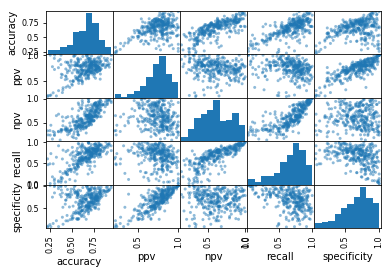

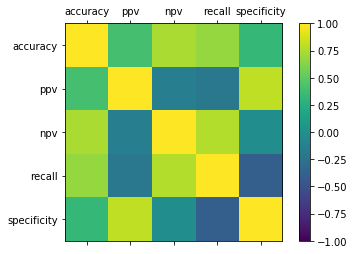

In [165]:
from pandas.plotting import scatter_matrix

labels = data[data.granularity == 'street'][label_cols]
scatter_matrix(labels, diagonal='hist')

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(labels.corr(), vmin=-1, vmax=1)
ax.set_xticklabels([''] + label_cols)
ax.set_yticklabels([''] + label_cols)
fig.colorbar(cax)
plt.show()

['accuracy', 'ppv', 'npv', 'recall', 'specificity']

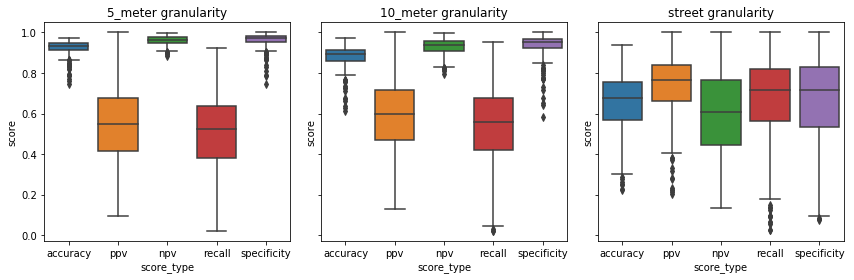

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

gran_types = ['5_meter', '10_meter', 'street']
fig, ax = plt.subplots(ncols=3, sharey=True)

for i, gran in enumerate(gran_types):
    labels = data[data.granularity == gran][label_cols] # labels with given granularity
    s = labels.stack().reset_index() # move all score types to one column
    s.columns = ['index', 'score_type', 'score']
    
    b = sns.boxplot(x=s['score_type'], y=s['score'], ax=ax[i])
    b.set_title(gran + ' granularity')
    
fig.set_size_inches(12,4)
fig.tight_layout()